# Flight Price Forecast – Kiwi

## Table of Contents
- [Introduction](#introduction)
- [Imports](#imports)
- [Data Preprocessing](#data-preprocessing)
- [Linear Regression](#linear-regression)
- [Decision Tree](#decision-tree)
- [Gaussian Process Regression](#gaussian-process-regression)
- [Random Forest](#random-forest)
- [GridSearchCV](#gridsearchcv)
- [KNN Regressor](#knn-regressor)
- [MLP Regressor](#mlp-regressor)
- [XG Boost Regressor](#xg-boost-regressor)
- [Hist Gradient Boosting](#hist-gradient-boosting)
- [Best Performance with Best Parameters](#best-performance-with-best-parameters)
- [Feature Importance](#feature-importance)
- [Conclusions](#conclusions)

---

## Introduction

The provided Python code develops a machine learning pipeline for predicting flight prices, starting with data preprocessing such as cleaning and converting price data, date extraction, duration conversion, and numeric encoding of categorical features like flight stops.  
The pipeline evaluates multiple regression methods, including Linear Regression, Decision Trees, Gaussian Process, Random Forests (with GridSearchCV optimization), K-Nearest Neighbors, Multi-layer Perceptron, XGBoost, and HistGradientBoostingRegressor, comparing their performance using metrics like R², RMSE, MSE, and MAE.

**Our Top models:** *"Random Forest"*, *"XGBoost"*, and *"HistGradientBoosting"* regressors demonstrated the strongest predictive performances, while significantly outperforming basic linear models.  
Using visualization tools such as residual plots, permutation importance, and predicted-versus-actual graphs provided insights into model accuracy and feature relevance.


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Data Preprocessing

In [4]:

df = pd.read_csv('kiwi_cleaned.csv')


print(df.head())
print(df.info())

   departure_hour departure_airport  flight_length  landing_hour  \
0       11.833333               SEN             70     14.000000   
1       11.833333               SEN             70     14.000000   
2       11.833333               SEN             70     14.000000   
3       18.583333               LTN             80     20.916667   
4       13.333333               LTN             80     15.666667   

  landing_airport to_dest_company  return_departure_hour  \
0             CDG         easyJet              11.833333   
1             CDG         easyJet              19.333333   
2             CDG         easyJet              15.166667   
3             CDG         easyJet              11.833333   
4             CDG         easyJet              11.833333   

   return_departure_airport  return_flight_length  return_landing_hour  ...  \
0                       NaN                    70            12.000000  ...   
1                       NaN                    65            19.416667  

In [7]:

df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('"', '', regex=False)
df['price'] = df['price'].str.replace("'", '', regex=False)
df['price'] = df['price'].str.replace(",", '', regex=False)
df['price'] = df['price'].str.strip()

# 2. המרה ל־float
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 3. הסרה של שורות בלי מחיר
df = df.dropna(subset=['price'])

# 4. בדיקה
print(df['price'].dtype)  # אמור להיות float64
print(df.shape)           # כמה שורות נשארו
        # כמה שורות נשארו


float64
(76713, 29)


In [8]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
df['departure_date'] = pd.to_datetime(df['departure_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

df['dep_weekday'] = df['departure_date'].dt.weekday
df['dep_day'] = df['departure_date'].dt.day
df['dep_month'] = df['departure_date'].dt.month
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x >= 5 else 0)


In [9]:
df['ttt'] = (df['departure_date'] - df['snapshot_date']).dt.days


In [12]:
df['Stops'] = df['layover'].astype(int)


In [13]:
features = ['Stops', 'Flight Duration Minutes', 'layover_time',
            'dep_weekday', 'dep_day', 'dep_month']

df.dropna(subset=features, inplace=True)

In [14]:
df.to_csv('kiwi_final.csv', index=False)


In [20]:
df.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,day_of_week,route,time_category,Flight Duration Minutes,Layover Minutes,dep_weekday,dep_day,dep_month,is_weekend,Stops
0,11.833333,SEN,70,14.000000,CDG,easyJet,11.833333,NaN,70,12.000000,...,Monday,LONDON_PARIS,Morning_6_12,0,0,0,3,3,0,0
1,11.833333,SEN,70,14.000000,CDG,easyJet,19.333333,NaN,65,19.416667,...,Monday,LONDON_PARIS,Morning_6_12,0,0,0,3,3,0,0
2,11.833333,SEN,70,14.000000,CDG,easyJet,15.166667,NaN,70,15.333333,...,Monday,LONDON_PARIS,Morning_6_12,0,0,0,3,3,0,0
3,18.583333,LTN,80,20.916667,CDG,easyJet,11.833333,NaN,70,12.000000,...,Monday,LONDON_PARIS,Evening_18_24,0,0,0,3,3,0,0
4,13.333333,LTN,80,15.666667,CDG,easyJet,11.833333,NaN,70,12.000000,...,Monday,LONDON_PARIS,Afternoon_12_18,0,0,0,3,3,0,0


# Model Training

In [22]:
# פיצ'רים רלוונטיים
features = ['Stops', 'flight_length', 'layover_time',
            'dep_weekday', 'dep_day', 'dep_month']

# חלוקה ל-Train ו-Test לפי ttt
train_df = df[df['ttt'] <= 25].copy()
test_df = df[df['ttt'] > 25].copy()

# יצירת X ו-y
X_train = train_df[features]
y_train = train_df['price']

X_test = test_df[features]
y_test = test_df['price']


In [23]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (68862, 6)
Test shape: (7851, 6)


In [24]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # אימון
    model.fit(X_train, y_train)
    
    # ניבוי
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # חישוב מדדים
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    # Residual Plot
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6,4))
    palette = sns.color_palette("viridis", n_colors=10) 
    color = palette[4]
    sns.scatterplot(x=y_pred_test, y=residuals, color=color, alpha=0.6, edgecolor='black')
    plt.axhline(y=0, color='r', linestyle='dashed', linewidth=2)
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.show()
    
    return model

# Linear Regression

=== Linear Regression ===
Train -> R2: 0.249, MSE: 1524.55, RMSE: 39.05, MAE: 31.93
Test  -> R2: -0.494,  MSE: 1804.15,  RMSE: 42.48,  MAE: 33.87


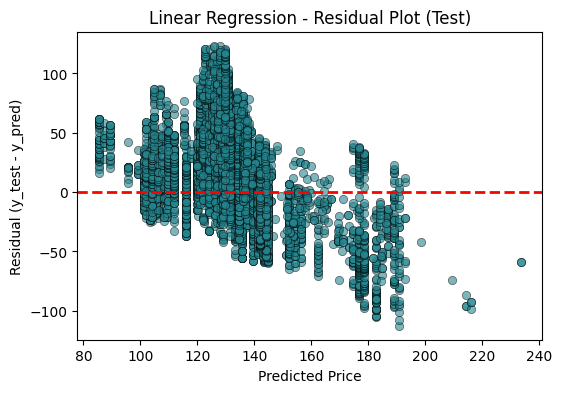

=== Linear Regression (StandardScaler) ===
Train -> R2: 0.249, MSE: 1524.55, RMSE: 39.05, MAE: 31.93
Test  -> R2: -0.494,  MSE: 1804.15,  RMSE: 42.48,  MAE: 33.87


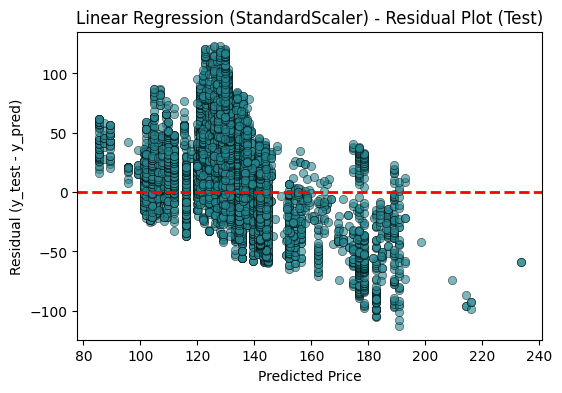

=== Linear Regression (MinMaxScaler) ===
Train -> R2: 0.249, MSE: 1524.55, RMSE: 39.05, MAE: 31.93
Test  -> R2: -0.494,  MSE: 1804.15,  RMSE: 42.48,  MAE: 33.87


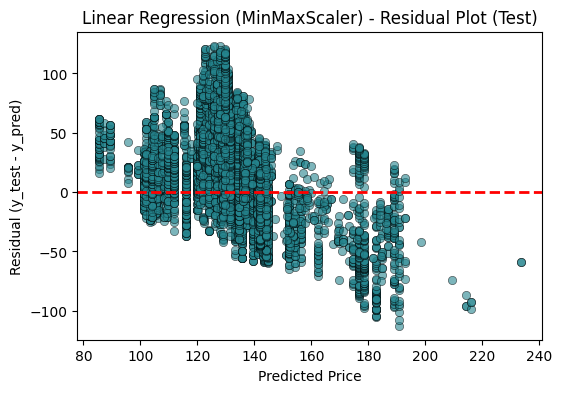

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. מודל לינארי רגיל
linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")

# 2. מודל לינארי עם StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

linreg_std = LinearRegression()
linreg_std = train_and_evaluate_model(linreg_std, X_train_std, y_train, X_test_std, y_test, "Linear Regression (StandardScaler)")

# 3. מודל לינארי עם MinMaxScaler
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

linreg_mm = LinearRegression()
linreg_mm = train_and_evaluate_model(linreg_mm, X_train_mm, y_train, X_test_mm, y_test, "Linear Regression (MinMaxScaler)")


## Conclusions – Linear Regression on Kiwi Dataset

###  Model Summary:
All three linear regression configurations (standard, StandardScaler, MinMaxScaler) underperformed on the Kiwi dataset.

- **R² (Train):** 0.249  
- **R² (Test):** –0.494 → Indicates the model performs worse than a constant baseline.
- **RMSE (Test):** 42.48  
- **MAE (Test):** 33.87

### Residual Diagnostics:
- Residuals exhibit clear structure and non-random patterns.
- A visible downward trend in the residual plot indicates systematic prediction errors.
- Violation of core linear regression assumptions (e.g., linearity, homoscedasticity).

###  Conclusion:
Linear regression fails to capture the underlying patterns in the data.  
Model generalization is poor, as seen by the negative R² and structured residuals.  
A more expressive, non-linear model (e.g., Random Forest or Gradient Boosting) is required to model the complexity in flight pricing.


# Decision-Tree

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.493, MSE: 1029.44, RMSE: 32.08, MAE: 24.95
Test  -> R2: 0.075,  MSE: 1117.18,  RMSE: 33.42,  MAE: 25.50


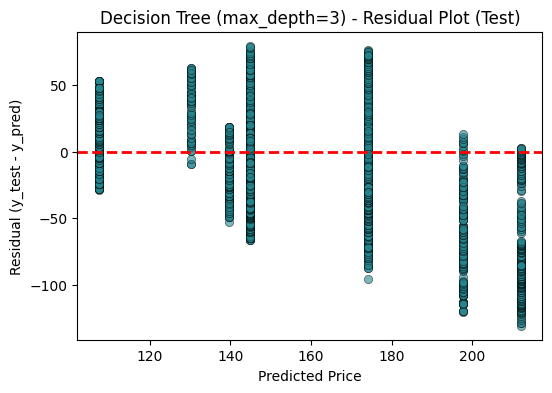

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.583, MSE: 846.23, RMSE: 29.09, MAE: 22.72
Test  -> R2: -0.143,  MSE: 1380.42,  RMSE: 37.15,  MAE: 27.55


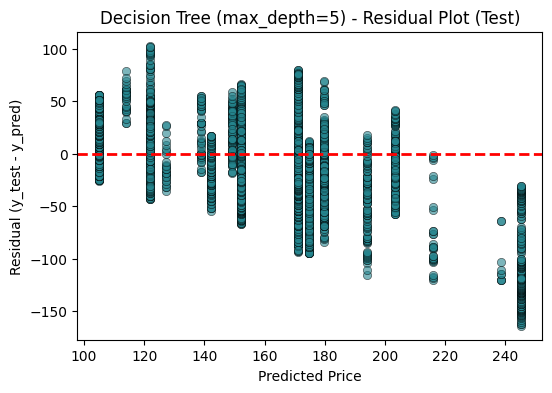

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.646, MSE: 717.82, RMSE: 26.79, MAE: 21.00
Test  -> R2: -0.023,  MSE: 1235.52,  RMSE: 35.15,  MAE: 26.08


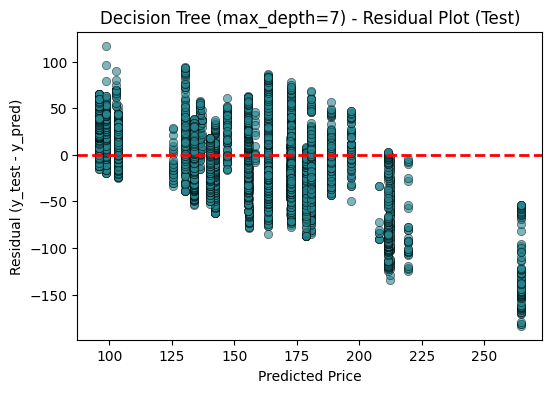

In [26]:
from sklearn.tree import DecisionTreeRegressor

for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


###  Decision Tree – Conclusions (Kiwi)

We evaluated Decision Tree models with `max_depth` values of 3, 5, and 7 on the Kiwi dataset.  
Below are the key findings:

####  Performance Summary:
- **Best train performance** was achieved with `max_depth=7` (R² = 0.646), but generalization was poor.
- **Best test performance** was with `max_depth=3` (R² = 0.075), but even this is a very weak predictive result.

####  Key Metrics (Test Set):
| Depth | R²    | RMSE   | MAE   |
|-------|-------|--------|-------|
|   3   | 0.075 | 33.42  | 25.50 |
|   5   | -0.143| 37.15  | 27.55 |
|   7   | -0.023| 35.15  | 26.08 |

#### Interpretation:
- **Overfitting trend**: As depth increases, the model fits the train data better, but test performance degrades.
- **Residual plots** show clear non-random patterns, indicating that the model struggles to generalize and systematically underperforms on certain price ranges.
- **R² remains low or negative** on the test set, suggesting that Decision Trees are not well-suited for this regression task without further tuning or feature engineering.

 **Conclusion**: While the model captures some structure in the training data, it fails to generalize effectively, and performance on unseen data remains poor across all depths.


# Gaussian Process Regression

=== GPR with RBF(length_scale=1) ===
Train -> R2: 0.026, MSE: 88.49, RMSE: 9.41, MAE: 8.39
Test  -> R2: -18.354,  MSE: 23379.51,  RMSE: 152.90,  MAE: 148.87


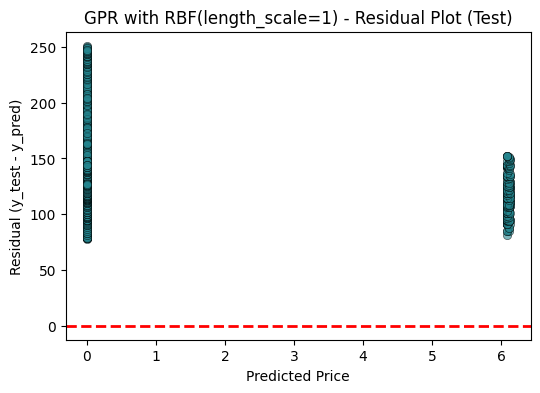

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.010, MSE: 89.92, RMSE: 9.48, MAE: 8.47
Test  -> R2: -206.374,  MSE: 250505.13,  RMSE: 500.50,  MAE: 479.79


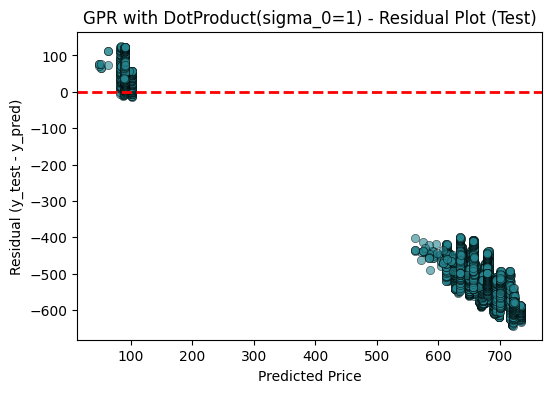

In [27]:
subset_size = 100  # למשל 100 דוגמאות
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,       # ביטול האופטימיזציה
            alpha=1e-6,           # להבטיח יציבות במספרים
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")

### Conclusions – Gaussian Process Regression (Kiwi)

**Performance Summary:**  
Gaussian Process Regression performed poorly on the Kiwi dataset.

---

**RBF Kernel (length_scale=1):**  
- R² (Test): -18.35, RMSE: 152.90 → High errors  
- Model overfits on limited range and fails to generalize

**DotProduct Kernel (sigma₀=1):**  
- R² (Test): -206.37, RMSE: 500.50 → Severe underperformance  
- Predictions are almost constant and meaningless

---

**Conclusion:**  
GPR with 100 training samples is not suitable for this data. Larger training sets or alternative models should be explored.